# Kaggle ANLP

## 1. Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string

c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Analyse des données d'entraînement

Nous chargeons le fichier CSV d'entraînement et affichons un aperçu, des informations sur le DataFrame et la distribution des classes.

In [2]:
train_df = pd.read_csv('train_submission.csv')

print("Aperçu du fichier d'entrainement")
display(train_df.head())

Aperçu du fichier d'entrainement


,Usage,Text,Label
0,Public,َ قَالَ النَّبِيُّ ص إِنِّي أَتَعَجَّبُ مِمَّن...,hau
1,Public,Filmen forteller historien om Will Hunting en...,nob
2,Public,An Arthrostylidium berryi in uska species han ...,wln
3,Public,Kancunarí enemigosniyquichejta munacuychej al...,quh
4,Public,Warmeqa ama yachachichunchu hermanospa tantaku...,quh


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190599 entries, 0 to 190598
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Usage   190599 non-null  object
 1   Text    190599 non-null  object
 2   Label   190099 non-null  object
dtypes: object(3)
memory usage: 4.4+ MB


Nombre de classes : 389

Distribution des classes :


Label
tgk    1500
kur    1000
hin    1000
aze    1000
bak    1000
       ... 
tvl       2
toi       1
kua       1
gcr       1
gaa       1
Name: count, Length: 389, dtype: int64

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_35748\1291918547.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=minority_classes.index, y=minority_classes.values, palette="magma")


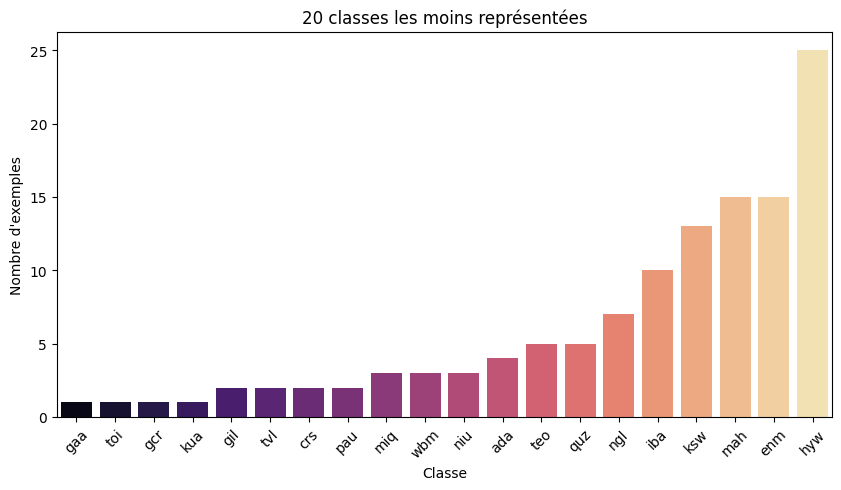

In [4]:
print(f"Nombre de classes : {train_df['Label'].nunique()}")
print("\nDistribution des classes :")
class_counts = train_df["Label"].value_counts()
display(class_counts)

#Visualisation des 20 classes les moins représentées
minority_classes = class_counts.sort_values().head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=minority_classes.index, y=minority_classes.values, palette="magma")
plt.title("20 classes les moins représentées")
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.xticks(rotation=45)
plt.show()


## 2. Prétraitement (optionel)

In [5]:
#Compilation unique des expressions régulières et préparation de la table de translation
URL_RE = re.compile(r"http\S+")
HTML_RE = re.compile(r"<.*?>")
PUNCT_TRANS = str.maketrans("", "", string.punctuation)
#Note : [^\w\s] signifie "tout ce qui n'est pas un caractère alphanumérique ou un espace"
NON_WORD_RE = re.compile(r"[^\w\s]")

def preprocess_text(text):
    """
    Nettoie le texte en le mettant en minuscule, en supprimant les URLs, le HTML,
    la ponctuation et tout caractère indésirable. Retourne le texte avec des espaces normalisés.
    """
    text = text.lower()
    text = URL_RE.sub("", text)
    text = HTML_RE.sub("", text)
    text = text.translate(PUNCT_TRANS)
    text = NON_WORD_RE.sub("", text)
    return " ".join(text.split())

## 3. Chargement et préparation des données

In [6]:
#Suppression des exemples avec des valeurs manquantes
train_df = train_df.dropna(subset=["Text", "Label"])

########A mettre en commentaire si on ne veut pas de prétraitement######
# Optionnel : Appliquer le prétraitement sur les textes!!!!!!!
train_df["Text"] = train_df["Text"].apply(preprocess_text)

#Création des mappings label -> id
labels = train_df["Label"].unique().tolist()
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}
train_df["label"] = train_df["Label"].map(label2id)

#Ensembles d'entraînement + validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

## 4. Tokenizer

In [10]:
#Conversion des DataFrames en datasets Hugging Face
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

#Chargement du tokenizer
model_checkpoint = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length=128)

#Tokenisation avec parallélisation et mise en cache
train_dataset = train_dataset.map(
    tokenize_function, batched=True)
val_dataset = val_dataset.map(
    tokenize_function, batched=True)

#Renommage de la colonne 'label' en 'labels' et configuration du format pour PyTorch
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:  13%|█▎        | 20000/152079 [00:05<00:38, 3386.66 examples/s]


KeyboardInterrupt: 

## 5. Entrainement du modèle

In [ ]:
num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


#Configuration de l'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=1,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

if torch.cuda.is_available():
    print("GPU détecté :", torch.cuda.get_device_name(0))
else:
    print("Aucun GPU détecté, l'entraînement se fera sur CPU.")

trainer.train()

#Évaluation sur l'ensemble de validation
eval_results = trainer.evaluate()
print("Résultats sur l'ensemble de validation :", eval_results)

#Sauvegarde du modèle et du tokenizer
model.save_pretrained("./best_model")
tokenizer.save_pretrained("./best_model")

## 6. Prédiction sur le jeu de test

In [ ]:
#Chargement et prétraitement du fichier de test
df_test = pd.read_csv("test_without_labels.csv")
df_test["Text"] = df_test["Text"].apply(preprocess_text)

#Conversion en Dataset et tokenisation
test_dataset = Dataset.from_pandas(df_test)
test_dataset = test_dataset.map(
    tokenize_function, batched=True, num_proc=4, load_from_cache_file=True
)
test_dataset.set_format("torch", columns=["input_ids", "attention_mask"])

#Prédiction
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

submission_df = pd.DataFrame(
    {"ID": list(range(1, len(preds) + 1)), "Label": [id2label[p] for p in preds]}
)
submission_df.to_csv("test_predictions_bert.csv", index=False)
print("Les prédictions ont été sauvegardées dans test_predictions_bert.csv")

## 7. Comparaison résultat

bert.py --> MEILLEUR  SCORE KAGGLE


Résultats sur l'ensemble de validation : {'eval_loss': 0.4813213646411896, 'eval_accuracy': 0.8608364018937401, 'eval_precision': 0.8654711895965098, 
'eval_recall': 0.8608364018937401, 'eval_f1': 0.8597720998389238, 'eval_runtime': 61.873, 'eval_samples_per_second': 614.484, 
'eval_steps_per_second': 38.417, 'epoch': 3.0}


xlmroberta --> 82% training


Résultats sur l'ensemble de validation : {'eval_loss': 0.6106075644493103, 'eval_accuracy': 0.822356654392425, 'eval_precision': 0.8253988192721808,
'eval_recall': 0.822356654392425, 'eval_f1': 0.8187619814309982, 'eval_runtime': 62.9596, 'eval_samples_per_second': 603.879, 'eval_steps_per_second': 18.885, 'epoch': 3.0}
